In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib.patches as mpatches
from help_funcs import *

In [2]:
import matplotlib

matplotlib.rcParams.update({'font.size': 14})

In [9]:
with open('base/results/PV_0.3_spikes.pickle','rb') as f:
    all_spikes = pickle.load(f)

In [211]:
def plot_raster(all_spikes, tmin = 1000, tmax = 3000):
    
    blue_patch = mpatches.Patch(color='blue', label='PV ChR2 stim')
    black_patch = mpatches.Patch(color='black', label='visual stim')


    order = 1000

    # test out plotting code   
    fig, axes = plt.subplots(3,1,figsize = (12,15),gridspec_kw = {'height_ratios':[4,1,1]})

    ax0 = axes[0]
#     ax0.set_title('contrast=0, local PV stim = 0.1')
    ax0.set_ylabel('Exc',fontsize=15)
    ax0.set_xticks([])
    ax0.set_ylim([0,8*order])
    ax0.set_xlim([tmin,tmax])
    for i in range(8*order):
        spikeTimes = all_spikes[:8*order][i][all_spikes[:8*order][i]<tmax]
        spikeTimes = spikeTimes[spikeTimes>tmin]
        index = i*np.ones(len(spikeTimes))
        ax0.plot(spikeTimes, index, linestyle='',marker='o', color='black',markersize=0.5)
#     ax0.add_patch(plt.Polygon((np.array([[1900,-200],[tmin,0],[tmin+100,-200]])),clip_on=False,color='black'))
#     ax0.add_patch(plt.Polygon((np.array([[2400,-200],[tmin+500,0],[tmin+600,-200]])),clip_on=False,color='black'))
#     ax0.add_patch(plt.Polygon((np.array([[2900,-200],[tmin+1000,0],[3100,-200]])),clip_on=False,color='black'))
#     ax0.add_patch(plt.Polygon((np.array([[3400,-200],[3500,0],[3600,-200]])),clip_on=False,color='black'))
#     ax0.add_patch(plt.Polygon((np.array([[3900,-200],[4000,0],[4100,-200]])),clip_on=False,color='black'))

    ax1 = axes[1]
    ax1.set_xlim([tmin,tmax])
    ax1.set_ylim([0,order])
    ax1.set_ylabel('PV',fontsize=15)
    ax1.set_xticks([])
    for i in range(1000):
        spikeTimes = all_spikes[8*order:9*order][i][all_spikes[8*order:9*order][i]<tmax]
        spikeTimes = spikeTimes[spikeTimes>tmin]
        index = i*np.ones(len(spikeTimes))
        ax1.plot(spikeTimes, index, linestyle='',marker='o', color='black',markersize=0.5)
#     ax1.add_patch(plt.Polygon((np.array([[2400,-200],[2500,0],[2600,-200]])),clip_on=False,color='blue'))
#     ax1.add_patch(plt.Polygon((np.array([[3400,-200],[3500,0],[3600,-200]])),clip_on=False,color='blue'))
#     ax1.legend(handles=[blue_patch,black_patch], loc='center left', bbox_to_anchor=(1, 1.7), fontsize=18)

    ax2 = axes[2]
    ax2.set_ylim([0,order])
    ax2.set_xlim([tmin,tmax])
    ax2.set_ylabel('SST',fontsize=15)
    ax2.set_xlabel('time, t (ms)',fontsize=20)
    for i in range(1000):
        spikeTimes = all_spikes[9*order:][i][all_spikes[9*order:][i]<tmax]
        spikeTimes = spikeTimes[spikeTimes>tmin]
        index = i*np.ones(len(spikeTimes))
        ax2.plot(spikeTimes, index, linestyle='',marker='o', color='black',markersize=0.5)

    plt.show()

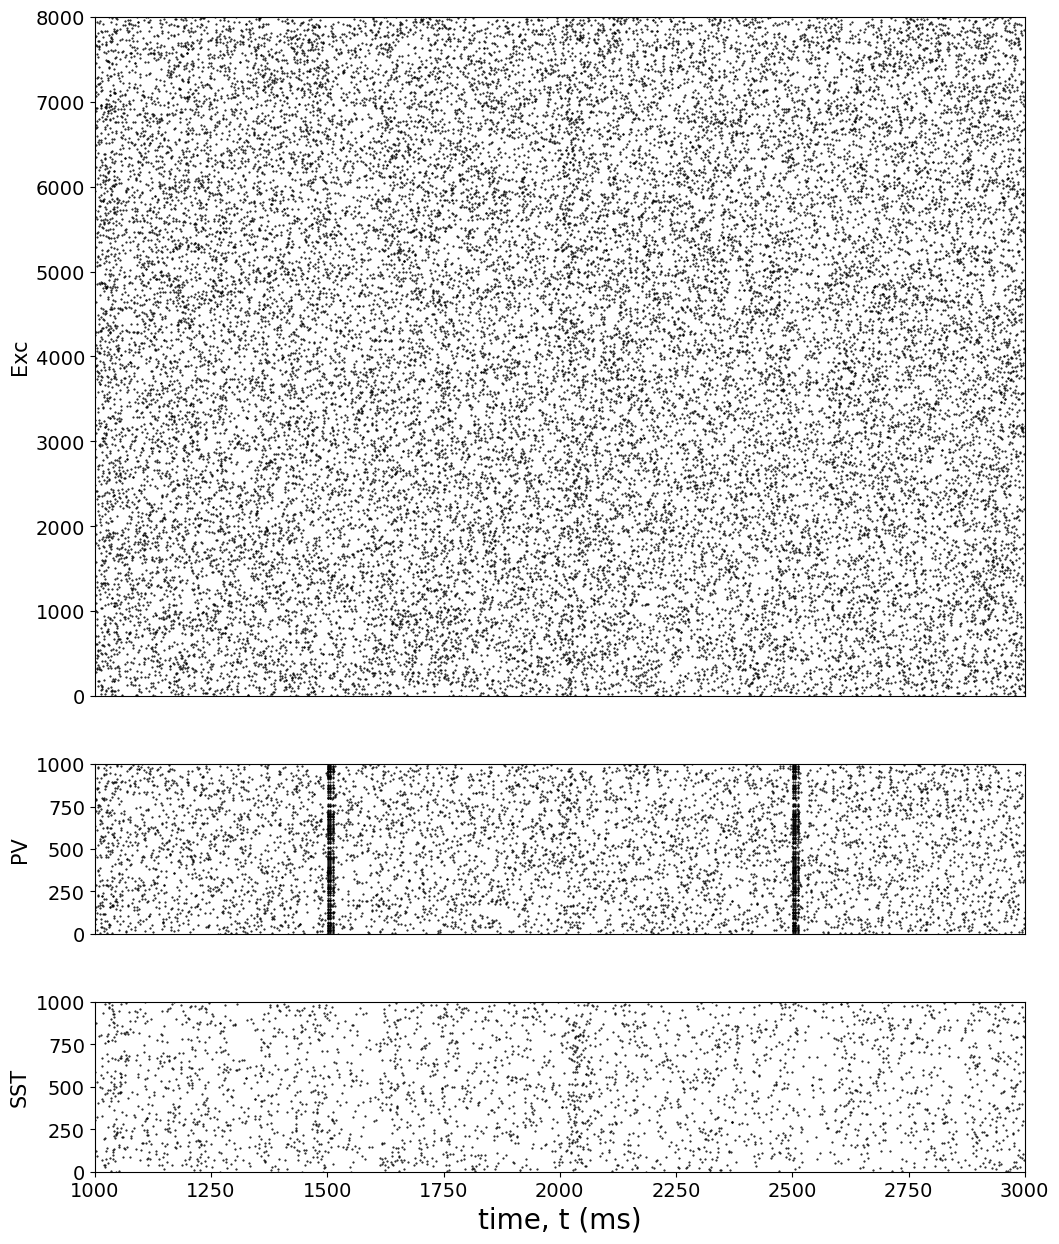

In [216]:
with open('base3/results/PV_0.3_spikes.pickle','rb') as f:
    all_spikes = pickle.load(f)
plot_raster(all_spikes)

In [3]:
def periodic_distance(p1, p2, L=1.0):
    """
    Calculates the periodic distance between two points on a 1x1 2-dimensional plane.

    Parameters
    ----------
    p1 : numpy array
        The first point, with shape (2,).
    p2 : numpy array
        The second point, with shape (2,).
    L : float
        The length of the periodic boundary, default value is 1.0.

    Returns
    -------
    distance : float
        The periodic distance between two points.
    """
    delta = np.abs(p1 - p2)
    delta = np.where(delta > L/2, L - delta, delta)
    return np.sqrt(np.sum(delta**2))


In [60]:
import scipy.stats
def getStimRateMeans(exc_spikes, exc_positions, rates=False):
    # store the control times and the chr2 stimulation times
    control_times = []
    chr_times = []
    ii = 0
    is_control = True
    while True:
        start_time = ii * 500 + 1000
        stop_time = start_time + 40
        if is_control:
            control_times.append(start_time)
        else:
            chr_times.append(start_time)   
        ii += 1
        if is_control:
            is_control = False
        else:
            is_control = True        
        if stop_time > 3000: break
#     print(control_times, chr_times)
    # compute the rates of the cells distal to the chr2 stimulus
    control_spikes = []
    chr_spikes = []
    center_pos = np.array([0.5,0.5])
    for ni in range(len(exc_positions)):
        pos_x, pos_y = exc_positions[ni,:]
        dist = np.sqrt((0.5-pos_x)**2 + (0.5-pos_y)**2)
        if dist > 0.2:
            continue
        nspikes = 0
        for tim in control_times:
            aa = exc_spikes[ni] [exc_spikes[ni] > tim ]
            aa = aa [aa < tim+40]
            nspikes += len(aa)
        control_spikes.append(nspikes)

        nspikes = 0
        for tim in chr_times:
            aa = exc_spikes[ni] [exc_spikes[ni] > tim ]
            aa = aa [aa < tim+40]
            nspikes += len(aa)
        chr_spikes.append(nspikes)
    control_rates = np.divide(control_spikes,(40/1000)) # convert from spike count to rate
    chr_rates = np.divide(chr_spikes,(40/1000))
    ctrl_mean = np.mean(control_rates)
    chr2_mean = np.mean(chr_rates)
    
    ctrl_err = scipy.stats.sem(control_rates)
    chr2_err = scipy.stats.sem(chr_rates)
    
    if rates:
        return [ctrl_mean, chr2_mean, ctrl_err, chr2_err, control_rates, chr_rates]
    else:
        return [ctrl_mean, chr2_mean, ctrl_err, chr2_err]

In [30]:
contrasts = np.array([0.05, 0.1, 0.18, 0.32])
# contrasts = np.array([0.02, 0.05, 0.2, 0.3])
# contrasts = np.array([0.02,  0.2])
ctrl_pv_curve = [[] for i in range(4)]
stim_pv_curve = [[] for i in range(4)]
ctrl_sst_curve = [[] for i in range(4)]
stim_sst_curve = [[] for i in range(4)]

ctrl_pv_curve_e = [[] for i in range(4)]
stim_pv_curve_e = [[] for i in range(4)]
ctrl_sst_curve_e = [[] for i in range(4)]
stim_sst_curve_e = [[] for i in range(4)]

folder = 'b2/results/'
for cont in contrasts:
   
    with open(folder + 'PV_%s_spikes.pickle'%cont, 'rb') as f:
        all_spikes = pickle.load(f)
    with open(folder + 'PV_%s_positions.pickle'%cont, 'rb') as f:
        all_positions = pickle.load(f)
        
    ctrlpv_E_mean, stimpv_E_mean, ctrlpv_E_err, stimpv_E_err = getStimRateMeans(all_spikes[:8000], all_positions[:8000])
    ctrlpv_P_mean, stimpv_P_mean, ctrlpv_P_err, stimpv_P_err = getStimRateMeans(all_spikes[8000:9000], all_positions[8000:9000])
    ctrlpv_S_mean, stimpv_S_mean, ctrlpv_S_err, stimpv_S_err = getStimRateMeans(all_spikes[9000:10000], all_positions[9000:10000])
    ctrlpv_A_mean, stimpv_A_mean, ctrlpv_A_err, stimpv_A_err = getStimRateMeans(all_spikes, all_positions)
    
    ctrl_pv_curve[0].append(ctrlpv_E_mean)
    ctrl_pv_curve[1].append(ctrlpv_P_mean)
    ctrl_pv_curve[2].append(ctrlpv_S_mean)
    ctrl_pv_curve[3].append(ctrlpv_A_mean)
    ctrl_pv_curve_e[0].append(ctrlpv_E_err)
    ctrl_pv_curve_e[1].append(ctrlpv_P_err)
    ctrl_pv_curve_e[2].append(ctrlpv_S_err)
    ctrl_pv_curve_e[3].append(ctrlpv_A_err)
    
    stim_pv_curve[0].append(stimpv_E_mean)
    stim_pv_curve[1].append(stimpv_P_mean)
    stim_pv_curve[2].append(stimpv_S_mean)
    stim_pv_curve[3].append(stimpv_A_mean)
    stim_pv_curve_e[0].append(stimpv_E_err)
    stim_pv_curve_e[1].append(stimpv_P_err)
    stim_pv_curve_e[2].append(stimpv_S_err)
    stim_pv_curve_e[3].append(stimpv_A_err)
    
    with open(folder + 'SOM_%s_spikes.pickle'%cont, 'rb') as f:
        all_spikes = pickle.load(f)
    with open(folder + 'SOM_%s_positions.pickle'%cont, 'rb') as f:
        all_positions = pickle.load(f)
        
    ctrlsst_E_mean, stimsst_E_mean, ctrlsst_E_err, stimsst_E_err = getStimRateMeans(all_spikes[:8000], all_positions[:8000])
    ctrlsst_P_mean, stimsst_P_mean, ctrlsst_P_err, stimsst_P_err = getStimRateMeans(all_spikes[8000:9000], all_positions[8000:9000])
    ctrlsst_S_mean, stimsst_S_mean, ctrlsst_S_err, stimsst_S_err = getStimRateMeans(all_spikes[9000:10000], all_positions[9000:10000])
    ctrlsst_A_mean, stimsst_A_mean, ctrlsst_A_err, stimsst_A_err = getStimRateMeans(all_spikes, all_positions)

    
    ctrl_sst_curve[0].append(ctrlsst_E_mean)
    ctrl_sst_curve[1].append(ctrlsst_P_mean)
    ctrl_sst_curve[2].append(ctrlsst_S_mean)
    ctrl_sst_curve[3].append(ctrlsst_A_mean)
    ctrl_sst_curve_e[0].append(ctrlsst_E_err)
    ctrl_sst_curve_e[1].append(ctrlsst_P_err)
    ctrl_sst_curve_e[2].append(ctrlsst_S_err)
    ctrl_sst_curve_e[3].append(ctrlsst_A_err)

    stim_sst_curve[0].append(stimsst_E_mean)
    stim_sst_curve[1].append(stimsst_P_mean)
    stim_sst_curve[2].append(stimsst_S_mean)
    stim_sst_curve[3].append(stimsst_A_mean)
    stim_sst_curve_e[0].append(stimsst_E_err)
    stim_sst_curve_e[1].append(stimsst_P_err)
    stim_sst_curve_e[2].append(stimsst_S_err)
    stim_sst_curve_e[3].append(stimsst_A_err)
# contrasts = np.array([ 0.05, 0.1, 0.2, 0.3])

In [31]:
from scipy.optimize import curve_fit

def linear_model(x, a, b):
    return a * x + b

# Fit the model
params, cov = curve_fit(linear_model, contrasts, ctrl_sst_curve[0], sigma=ctrl_sst_curve_e[0])

# Extract the parameters and their errors
a, b = params
a_err, b_err = np.sqrt(np.diag(cov))
print(a,a_err)

6.515079914111958 0.769926879286572


In [114]:
import numpy as np
from scipy.optimize import curve_fit

# naka-rushton = (m+((Rm.*(x.^n))./((x.^n) + (c50.^n)))))
# parameter = [Rm, n, c50, m]
# p0 = [150, 5, 0.1, 50]
# Upper = [250, 30, 0.26, 200]
# Lower = [0, 0, 0.04, 0]
p0 = [50, 150, 5, 0.1] 
Upper = [200, 250, 30, 0.26]
# Lower = [0, 0, 0, 0.04]
Lower = [0, 0, 0, 0.06]
bounds = (Upper, Lower)

def naka_rushton(x, m, C, n, k):
    return m + C * (x**n) / (x**n + k**n)

def fit_naka_rushton(x, y, sigma=None, p0 = p0, bounds=bounds):
    params, cov = curve_fit(naka_rushton, x, y, sigma=sigma, p0=p0, maxfev = 1000000)
    return params, cov


# def naka_rushton(x, m, C, n):
#     return m + C * (x**n) / (x**n + 0.1**n)

# def fit_naka_rushton(x, y, sigma=None, p0 = [4., 2.0, 2.0]):
#     params, cov = curve_fit(naka_rushton, x, y, sigma=sigma, p0=p0, maxfev = 1000000)
#     return params, cov

# x = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
# y = np.array([0.1, 0.15, 0.3, 0.6, 0.8])

# C, n, k = fit_naka_rushton(contrasts, y)
# print("C =", C)
# print("n =", n)
# print("k =", k)


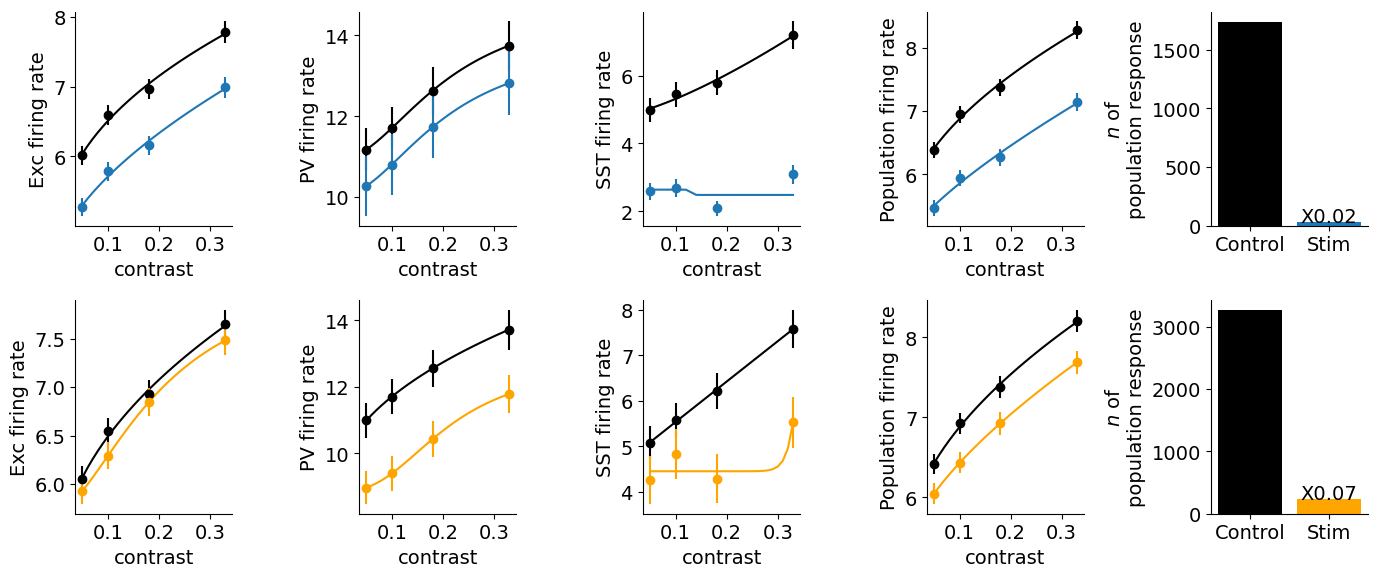

In [122]:
colors = {'ctrl_pv': 'black', 'stim_pv': 'tab:blue', 'ctrl_sst': 'black', 'stim_sst': 'orange'}

# define labels for PV and SST
labels = {'pv': 'PV stimulation', 'sst': 'SST stimulation'}

# define titles for E, P, and S
titles = {'E': 'Exc', 'P': 'PV', 'S': 'SST', 'A':'Population'}

# create subplots
fig, ax = plt.subplots(2, 5, figsize=(14, 6))
xvals = np.arange(0.05,0.33,0.01)
# loop over rows (PV and SST)
for i, y in enumerate(['pv', 'sst']):
    # loop over columns (E, P, and S)
    pop_slopes = []
    pop_errs = []
    for j, z in enumerate(['E', 'P', 'S', 'A']):
        # loop over ctrl and stim
        for x in ['ctrl', 'stim']:
            # get data from X_Y_Z arrays
            data = eval(f"{x}_{y}_curve[{j}]")
            errs = eval(f"{x}_{y}_curve_e[{j}]")
#             datp = eval(f"{x}_{y}_datp[{j}]")
            # plot the data with specified color
            ax[i, j].errorbar(contrasts, data, yerr=errs, color=colors[f"{x}_{y}"], fmt='o')
            
            params, cov = fit_naka_rushton(contrasts, data, sigma=errs)
#             m, C, n, k = params
# m_err, C_err, n_err, k_err = np.sqrt(np.diag(cov))
            m, C, n, k = params
            m_err, C_err, n_err, k_err = np.sqrt(np.diag(cov))
#             ax[i, j].plot(xvals, naka_rushton(xvals, m, C, n,k), color=colors[f"{x}_{y}"])
            ax[i, j].plot(xvals, naka_rushton(xvals, m, C, n, k), color=colors[f"{x}_{y}"])
            
            if z == 'A':
                pop_slopes.append(C*n*(k**(1-2*n))/4)
                pop_errs.append(0)
#             ax[i, j].plot(contrasts, data, color=colors[f"{x}_{y}"])
        # set title for each subplot
#         ax[i, j].set_title(titles[z])
        ax[i, j].set_ylabel(f"{titles[z]} firing rate")
        ax[i, j].set_xlabel('contrast')
        ax[i,j].spines[['right', 'top']].set_visible(False)
        

    for j,x in enumerate(['ctrl', 'stim']):
        ax[i, 4].bar([j],pop_slopes[j], color=colors[f"{x}_{y}"])
        ax[i, 4].errorbar([j],pop_slopes[j],yerr=pop_errs[j], color=colors[f"{x}_{y}"])
    ax[i,4].set_ylabel('$n$ of\npopulation response')
    ax[i,4].set_xticks([0,1], ['Control', 'Stim'])
    ax[i,4].spines[['right', 'top']].set_visible(False)
    ax[i,4].text(1,pop_slopes[j]+pop_errs[j]+0.5,'X%.2f'%(pop_slopes[1]/pop_slopes[0]), horizontalalignment='center')

# set labels for each row
# ax[0, 0].set_ylabel(labels['pv'])
# ax[1, 0].set_ylabel(labels['sst'])
plt.tight_layout()

# show the plot
# plt.savefig('result_figs/nl_long.eps')
plt.show()


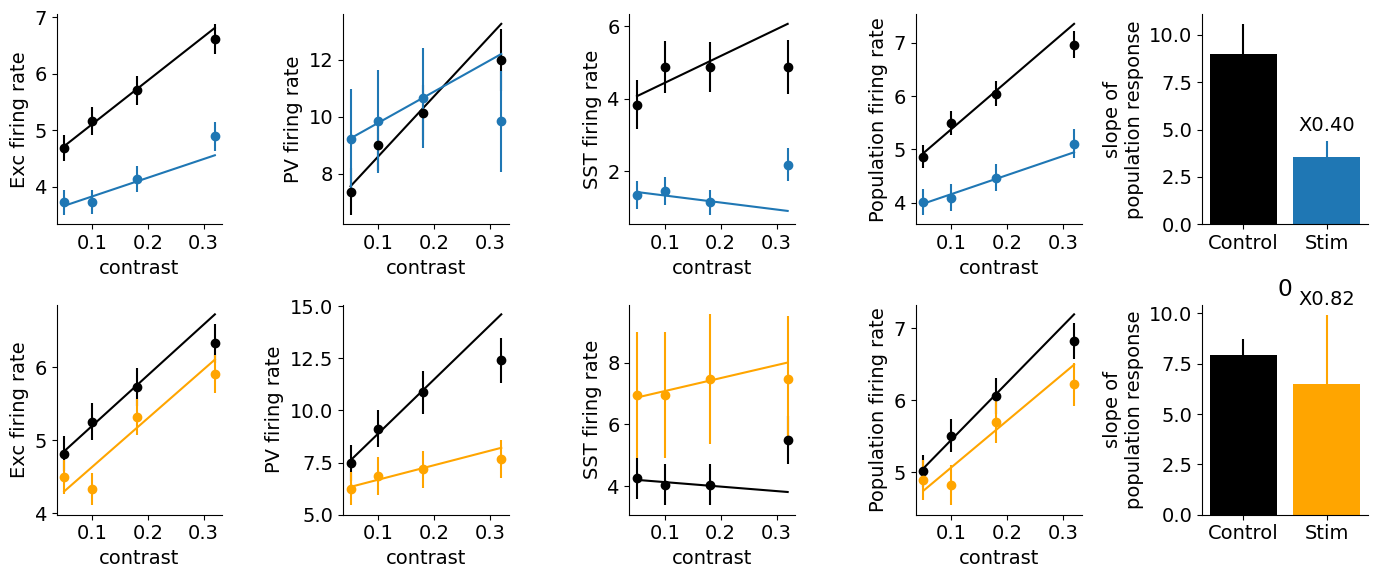

In [101]:
colors = {'ctrl_pv': 'black', 'stim_pv': 'tab:blue', 'ctrl_sst': 'black', 'stim_sst': 'orange'}

# define labels for PV and SST
labels = {'pv': 'PV stimulation', 'sst': 'SST stimulation'}

# define titles for E, P, and S
titles = {'E': 'Exc', 'P': 'PV', 'S': 'SST', 'A':'Population'}

# create subplots
fig, ax = plt.subplots(2, 5, figsize=(14, 6))

# loop over rows (PV and SST)
for i, y in enumerate(['pv', 'sst']):
    # loop over columns (E, P, and S)
    pop_slopes = []
    pop_errs = []
    for j, z in enumerate(['E', 'P', 'S', 'A']):
        # loop over ctrl and stim
        for x in ['ctrl', 'stim']:
            # get data from X_Y_Z arrays
            data = eval(f"{x}_{y}_curve[{j}]")
            errs = eval(f"{x}_{y}_curve_e[{j}]")
#             datp, xx = eval(f"{x}_{y}_datp[{j}]")
            # plot the data with specified color
            ax[i, j].errorbar(contrasts, data, yerr=errs, color=colors[f"{x}_{y}"], fmt='o')
            
            params, cov = curve_fit(linear_model, contrasts[:-1], data[:-1], sigma=errs[:-1])
            a, b = params
            a_err, b_err = np.sqrt(np.diag(cov))
            ax[i, j].plot(contrasts, contrasts*a + b, color=colors[f"{x}_{y}"])
            
            if z == 'A':
                pop_slopes.append(a)
                pop_errs.append(a_err)
#             ax[i, j].plot(contrasts, data, color=colors[f"{x}_{y}"])
        # set title for each subplot
#         ax[i, j].set_title(titles[z])
        ax[i, j].set_ylabel(f"{titles[z]} firing rate")
        ax[i, j].set_xlabel('contrast')
        ax[i,j].spines[['right', 'top']].set_visible(False)
        

    for j,x in enumerate(['ctrl', 'stim']):
        ax[i, 4].bar([j],pop_slopes[j], color=colors[f"{x}_{y}"])
        ax[i, 4].errorbar([j],pop_slopes[j],yerr=pop_errs[j], color=colors[f"{x}_{y}"])
    ax[i,4].set_ylabel('slope of\npopulation response')
    ax[i,4].set_xticks([0,1], ['Control', 'Stim'])
    ax[i,4].spines[['right', 'top']].set_visible(False)
    ax[i,4].text(1,pop_slopes[j]+pop_errs[j]+0.5,'X%.2f'%(pop_slopes[1]/pop_slopes[0]), horizontalalignment='center')

# set labels for each row
# ax[0, 0].set_ylabel(labels['pv'])
# ax[1, 0].set_ylabel(labels['sst'])
plt.tight_layout()

# show the plot
# plt.savefig('result_figs/rand_p5.eps')
plt.title("0")
plt.show()

In [34]:
import scipy.stats
def getStimRates(exc_spikes, exc_positions):
    # store the control times and the chr2 stimulation times
    control_times = []
    chr_times = []
    ii = 0
    is_control = True
    while True:
        start_time = ii * 500 + 1000
        stop_time = start_time + 40
        if is_control:
            control_times.append(start_time)
        else:
            chr_times.append(start_time)   
        ii += 1
        if is_control:
            is_control = False
        else:
            is_control = True        
        if stop_time > 3000: break
#     print(control_times, chr_times)
    # compute the rates of the cells distal to the chr2 stimulus
    control_spikes = []
    chr_spikes = []
    center_pos = np.array([0.5,0.5])
    for ni in range(len(exc_positions)):
        pos_x, pos_y = exc_positions[ni,:]
        dist = np.sqrt((0.5-pos_x)**2 + (0.5-pos_y)**2)
        if dist > 0.2:
            continue
        nspikes = 0
        for tim in control_times:
            aa = exc_spikes[ni] [exc_spikes[ni] > tim ]
            aa = aa [aa < tim+40]
            nspikes += len(aa)
        control_spikes.append(nspikes)

        nspikes = 0
        for tim in chr_times:
            aa = exc_spikes[ni] [exc_spikes[ni] > tim ]
            aa = aa [aa < tim+40]
            nspikes += len(aa)
        chr_spikes.append(nspikes)
    control_rates = np.divide(control_spikes,(40/1000)) # convert from spike count to rate
    chr_rates = np.divide(chr_spikes,(40/1000))
#     ctrl_mean = np.mean(control_rates)
#     chr2_mean = np.mean(chr_rates)
    
#     ctrl_err = scipy.stats.sem(control_rates)
#     chr2_err = scipy.stats.sem(chr_rates)
    
    return control_rates, chr_rates

In [121]:
contrasts = np.array([0.05, 0.1, 0.18, 0.33])
# contrasts = np.array([0.02, 0.05, 0.2, 0.3])
# contrasts = np.array([0.02,  0.2])
ctrl_pv_curve = [[] for i in range(4)]
stim_pv_curve = [[] for i in range(4)]
ctrl_sst_curve = [[] for i in range(4)]
stim_sst_curve = [[] for i in range(4)]

ctrl_pv_curve_e = [[] for i in range(4)]
stim_pv_curve_e = [[] for i in range(4)]
ctrl_sst_curve_e = [[] for i in range(4)]
stim_sst_curve_e = [[] for i in range(4)]

ctrl_pv_datp = [[] for i in range(4)]
stim_pv_datp = [[] for i in range(4)]
ctrl_sst_datp = [[] for i in range(4)]
stim_sst_datp = [[] for i in range(4)]


seeds = [12345, 23456, 34567, 45678, 56789, 67890, 78901, 89012, 90123, 1234]
seeds = [12345, 23456, 34567, 45678, 1, 2, 3, 4]
flist = ['base3c/results_%s/'%s for s in seeds]

for cont in contrasts:
    
    E_spikes, P_spikes, S_spikes, A_spikes = [], [], [], []
    E_positions, P_positions, S_positions, A_positions = [], [], [], []
    
    for folder in flist:
        with open(folder + 'PV_%s_spikes.pickle'%cont, 'rb') as f:
            all_spikes = pickle.load(f)
        with open(folder + 'PV_%s_positions.pickle'%cont, 'rb') as f:
            all_positions = pickle.load(f)
        E_spikes += all_spikes[:8000]
        P_spikes += all_spikes[8000:9000]
        S_spikes += all_spikes[9000:10000]
        A_spikes += all_spikes
        
        E_positions += [all_positions[:8000]]
        P_positions += [all_positions[8000:9000]]
        S_positions += [all_positions[9000:10000]]
        A_positions += [all_positions]
        
    

    E_positions = np.concatenate(E_positions, axis=0)
    P_positions = np.concatenate(P_positions, axis=0)
    S_positions = np.concatenate(S_positions, axis=0)
    A_positions = np.concatenate(A_positions, axis=0)
    
    print(A_positions.shape)
        
    ctrlpv_E_mean, stimpv_E_mean, ctrlpv_E_err, stimpv_E_err, ctrlpv_E_rates, stimpv_E_rates = getStimRateMeans(E_spikes, E_positions, rates=True)
    ctrlpv_P_mean, stimpv_P_mean, ctrlpv_P_err, stimpv_P_err, ctrlpv_P_rates, stimpv_P_rates = getStimRateMeans(P_spikes, P_positions, rates=True)
    ctrlpv_S_mean, stimpv_S_mean, ctrlpv_S_err, stimpv_S_err, ctrlpv_S_rates, stimpv_S_rates = getStimRateMeans(S_spikes, S_positions, rates=True)
    ctrlpv_A_mean, stimpv_A_mean, ctrlpv_A_err, stimpv_A_err, ctrlpv_A_rates, stimpv_A_rates = getStimRateMeans(A_spikes, A_positions, rates=True)
    
    ctrl_pv_curve[0].append(ctrlpv_E_mean)
    ctrl_pv_curve[1].append(ctrlpv_P_mean)
    ctrl_pv_curve[2].append(ctrlpv_S_mean)
    ctrl_pv_curve[3].append(ctrlpv_A_mean)
    ctrl_pv_curve_e[0].append(ctrlpv_E_err)
    ctrl_pv_curve_e[1].append(ctrlpv_P_err)
    ctrl_pv_curve_e[2].append(ctrlpv_S_err)
    ctrl_pv_curve_e[3].append(ctrlpv_A_err)
    ctrl_pv_datp[0].append(ctrlpv_E_rates)
    ctrl_pv_datp[1].append(ctrlpv_P_rates)
    ctrl_pv_datp[2].append(ctrlpv_S_rates)
    ctrl_pv_datp[3].append(ctrlpv_A_rates)
    
    stim_pv_curve[0].append(stimpv_E_mean)
    stim_pv_curve[1].append(stimpv_P_mean)
    stim_pv_curve[2].append(stimpv_S_mean)
    stim_pv_curve[3].append(stimpv_A_mean)
    stim_pv_curve_e[0].append(stimpv_E_err)
    stim_pv_curve_e[1].append(stimpv_P_err)
    stim_pv_curve_e[2].append(stimpv_S_err)
    stim_pv_curve_e[3].append(stimpv_A_err)
    stim_pv_datp[0].append(stimpv_E_rates)
    stim_pv_datp[1].append(stimpv_P_rates)
    stim_pv_datp[2].append(stimpv_S_rates)
    stim_pv_datp[3].append(stimpv_A_rates)
    
    E_spikes, P_spikes, S_spikes, A_spikes = [], [], [], []
    E_positions, P_positions, S_positions, A_positions = [], [], [], []

    for folder in flist:
        with open(folder + 'SOM_%s_spikes.pickle'%cont, 'rb') as f:
            all_spikes = pickle.load(f)
        with open(folder + 'SOM_%s_positions.pickle'%cont, 'rb') as f:
            all_positions = pickle.load(f)
        E_spikes += all_spikes[:8000]
        P_spikes += all_spikes[8000:9000]
        S_spikes += all_spikes[9000:10000]
        A_spikes += all_spikes
        
        E_positions += [all_positions[:8000]]
        P_positions += [all_positions[8000:9000]]
        S_positions += [all_positions[9000:10000]]
        A_positions += [all_positions]

    E_positions = np.concatenate(E_positions, axis=0)
    P_positions = np.concatenate(P_positions, axis=0)
    S_positions = np.concatenate(S_positions, axis=0)
    A_positions = np.concatenate(A_positions, axis=0)

        
    ctrlsst_E_mean, stimsst_E_mean, ctrlsst_E_err, stimsst_E_err, ctrlsst_E_rates, stimsst_E_rates = getStimRateMeans(E_spikes, E_positions, rates=True)
    ctrlsst_P_mean, stimsst_P_mean, ctrlsst_P_err, stimsst_P_err, ctrlsst_P_rates, stimsst_P_rates = getStimRateMeans(P_spikes, P_positions, rates=True)
    ctrlsst_S_mean, stimsst_S_mean, ctrlsst_S_err, stimsst_S_err, ctrlsst_S_rates, stimsst_S_rates = getStimRateMeans(S_spikes, S_positions, rates=True)
    ctrlsst_A_mean, stimsst_A_mean, ctrlsst_A_err, stimsst_A_err, ctrlsst_A_rates, stimsst_A_rates = getStimRateMeans(A_spikes, A_positions, rates=True)
     
    ctrl_sst_curve[0].append(ctrlsst_E_mean)
    ctrl_sst_curve[1].append(ctrlsst_P_mean)
    ctrl_sst_curve[2].append(ctrlsst_S_mean)
    ctrl_sst_curve[3].append(ctrlsst_A_mean)
    ctrl_sst_curve_e[0].append(ctrlsst_E_err)
    ctrl_sst_curve_e[1].append(ctrlsst_P_err)
    ctrl_sst_curve_e[2].append(ctrlsst_S_err)
    ctrl_sst_curve_e[3].append(ctrlsst_A_err)
    ctrl_sst_datp[0].append(ctrlsst_E_rates)
    ctrl_sst_datp[1].append(ctrlsst_P_rates)
    ctrl_sst_datp[2].append(ctrlsst_S_rates)
    ctrl_sst_datp[3].append(ctrlsst_A_rates)

    stim_sst_curve[0].append(stimsst_E_mean)
    stim_sst_curve[1].append(stimsst_P_mean)
    stim_sst_curve[2].append(stimsst_S_mean)
    stim_sst_curve[3].append(stimsst_A_mean)
    stim_sst_curve_e[0].append(stimsst_E_err)
    stim_sst_curve_e[1].append(stimsst_P_err)
    stim_sst_curve_e[2].append(stimsst_S_err)
    stim_sst_curve_e[3].append(stimsst_A_err)
    stim_sst_datp[0].append(stimsst_E_rates)
    stim_sst_datp[1].append(stimsst_P_rates)
    stim_sst_datp[2].append(stimsst_S_rates)
    stim_sst_datp[3].append(stimsst_A_rates)


(80000, 2)
(80000, 2)
(80000, 2)
(80000, 2)
